# Ubermag example: Vortex dynamics

In this example, we are going to simulate vortex core dynamics - we are first going to displace it by applying an external magnetic field, and then turn it off to simulate the vortex core dynamics.

The sample is a two-dimensional Permalloy square sample with $d=100 \,\text{nm}$ edge length and $5\,\text{nm}$ thickness. Its energy equation consists of ferromagnetic exchange, Zeeman, and demagnetisation energy terms:
    
$$E = \int_{V} \left[-A\mathbf{m}\cdot\nabla^{2}\mathbf{m} - \mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H} + w_\text{d}\right] \text{d}V,$$

where $A = 13 \,\text{pJ}\,\text{m}^{-1}$ is the exchange energy constant, $M_\text{s} = 8 \times 10^{5} \,\text{A}\,\text{m}^{-1}$ magnetisation saturation, $w_\text{d}$ demagnetisation energy density, and $\mathbf{H}$ an external magnetic field, with $\mathbf{m}=\mathbf{M}/M_\text{s}$ being the normalised magnetisation field.

The magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation consisting of precession and damping terms:

$$\frac{\partial\mathbf{m}}{\partial t} = -\frac{\gamma_{0}}{1+\alpha^{2}}\mathbf{m}\times\mathbf{H}_\text{eff} - \frac{\gamma_{0}\alpha}{1+\alpha^{2}}\mathbf{m}\times(\mathbf{m}\times\mathbf{H}_\text{eff}),$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and $\alpha = 0.2$ is the Gilbert damping.

The (initial) magnetisation field is a vortex state, whose magnetisation at each point $(x, y, z)$ in the sample can be represented as $(m_{x}, m_{y}, m_{z}) = (-cy, cx, 0.1)$, with $c = 10^{9} \text{m}^{-1}$.

The Ubermag code for defining the micromagnetic system is:

In [1]:
import discretisedfield as df
import micromagneticmodel as mm

# Geometry
L = 100e-9  # sample edge length (m)
thickness = 5e-9  # sample thickness (m)

# Material (Permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 13e-12  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.2  # Gilbert damping

system = mm.System(name='vortex_dynamics')

# Energy equation. We omit Zeeman energy term, because H=0.
system.energy = mm.Exchange(A=A) + mm.Demag()

# Dynamics equation
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

region = df.Region(p1=(-L/2, -L/2, 0), p2=(L/2, L/2, thickness))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

def m_init(point):
    x, y, z = point
    c = 1e9  # (1/m)
    return (-c*y, c*x, 0.1)

system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

The system object is now defined and we can investigate some of its properties:

In [2]:
system.energy

Exchange(A=1.3e-11) + Demag()

In [3]:
system.dynamics

Precession(gamma0=221100.0) + Damping(alpha=0.2)

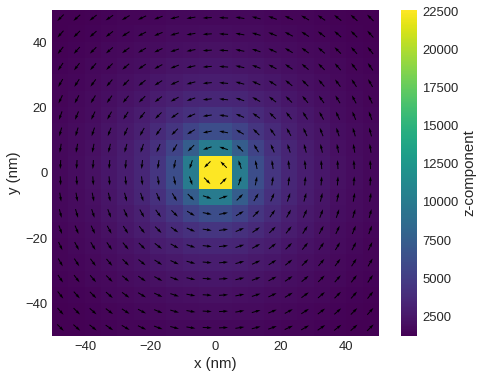

In [4]:
system.m.plane('z').mpl()

We can now relax the system in the absence of external magnetic field using energy minimisation driver (`MinDriver`):

Running OOMMF (ExeOOMMFRunner) [2021/03/12 17:59]... (0.9 s)


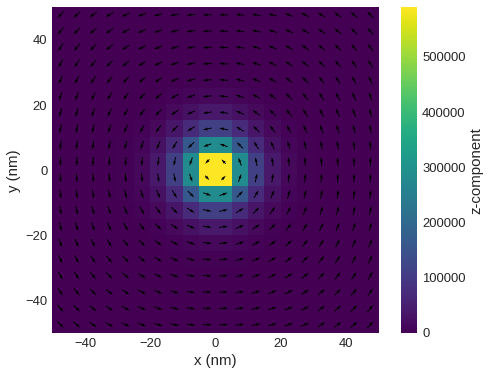

In [5]:
import oommfc as mc

md = mc.MinDriver()
md.drive(system)

system.m.plane('z').mpl()

Now, we have a relaxed vortex state, with its core at the centre of the sample. As the next step, we want to add an external magnetic field $H=10^{4}\,\text{Am}^{-1}$ in the positive $x$-direction to displace the vortex core. We do that by adding the Zeeman energy term to the energy equation:

Running OOMMF (ExeOOMMFRunner) [2021/03/12 17:59]... (1.1 s)


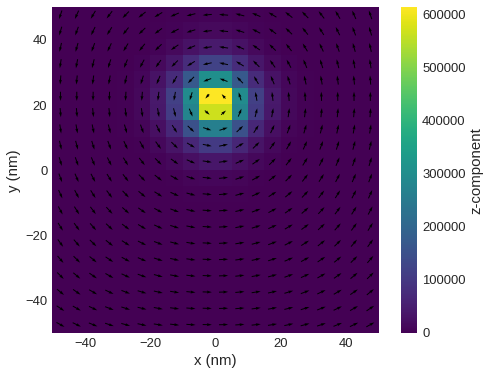

In [6]:
H = (1e4, 0, 0)  # an external magnetic field (A/m)

system.energy += mm.Zeeman(H=H)

md.drive(system)
system.m.plane('z').mpl()

The vortex core is now displaced in the positive $y$-direction. As the last step, we are going to turn off the external magnetic field and simulate dynamics using `TimeDriver`. We are going to run simulation for $5\,\text{ns}$ and save the magnetisation in $500$ steps.

In [7]:
system.energy.zeeman.H = (0, 0, 0)

td = mc.TimeDriver()
td.drive(system, t=5e-9, n=500)

Running OOMMF (ExeOOMMFRunner) [2021/03/12 17:59]... (5.3 s)


The final magnetisation state shows that the vortex core has moved back to the sample's centre.

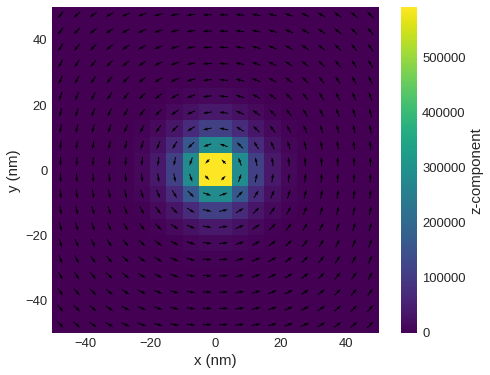

In [8]:
system.m.plane('z').mpl()

We can also visualise $M_{z}$ using interactive three-dimensional plot.

In [9]:
system.m.z.plane('z').k3d_scalar()

Output()

Table with scalar data saved during the simulation is:

In [10]:
system.table.data.tail()

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_exchange,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,E_demag,E_zeeman,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
495,1.765512e-18,18364.0,1.350369,-1.014485e-15,-1.061081e-27,1.365677e-18,57.084565,57.084739,62.059613,3.998347e-19,0.0,3470.0,6.0,495.0,-0.000059,-0.000246,0.022938,9.829852e-13,4.960000e-09
496,1.765512e-18,18401.0,1.323030,-9.693090e-16,-1.010540e-27,1.365677e-18,57.083949,57.084565,62.059613,3.998347e-19,0.0,3477.0,6.0,496.0,-0.000038,-0.000244,0.022938,9.801675e-13,4.970000e-09
497,1.765512e-18,18438.0,1.303212,-9.261784e-16,-9.647776e-28,1.365677e-18,57.082995,57.083949,62.059613,3.998347e-19,0.0,3484.0,6.0,497.0,-0.000017,-0.000241,0.022938,9.795105e-13,4.980000e-09
498,1.765512e-18,18475.0,1.279160,-8.847427e-16,-9.218227e-28,1.365677e-18,57.081627,57.082995,62.059613,3.998346e-19,0.0,3491.0,6.0,498.0,0.000002,-0.000236,0.022938,9.796523e-13,4.990000e-09
499,1.765512e-18,18512.0,1.259471,-8.446590e-16,-8.809099e-28,1.365677e-18,57.079981,57.081627,62.059613,3.998346e-19,0.0,3498.0,6.0,499.0,0.000021,-0.000229,0.022938,9.803292e-13,5.000000e-09


We can now plot the average $m_{x}$ and $m_{y}$ as a function of time to give us an idea of the vortex core position.

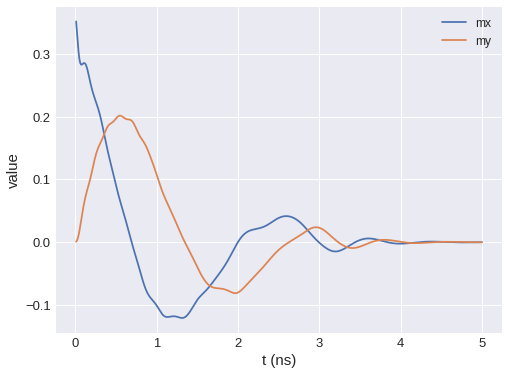

In [11]:
system.table.mpl(y=['mx', 'my'])

Finally, we are going to have a look at the magnetisation field at different time-steps using `micromagneticdata`.

In [12]:
import micromagneticdata as md

data = md.Data(system.name)
data.info

,drive_number,date,time,driver,t,n
0,0,2021-03-12,17:59:13,MinDriver,NaN,NaN
1,1,2021-03-12,17:59:15,MinDriver,NaN,NaN
2,2,2021-03-12,17:59:16,TimeDriver,5.000000e-09,500.0


We can also create a plot to interactively inspect the magnetisation at different time-steps.

In [13]:
@df.interact(nstep=data[-1].slider(continuous_update=False))
def our_interactive_plot(nstep):
    data[-1][nstep].plane('z').mpl()

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=499), Output()), _do…

Finally, let us delete all simulation files:

In [14]:
# mc.delete(system)